# Software analytics: Increase code review speed — impact on global colaboration in large projects

Let's import the necessary libraries and load the data.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kruskal, spearmanr, mannwhitneyu

The data we will be using is found :

https://zenodo.org/records/3922907

In [11]:
data = pd.read_csv('./data/new_pullreq.csv', header=0)
data

,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,stylelint,stylelint,1,237,237.0,1,0,0,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,Joaogarciadelima,checklistos,0,1410,NaN,1,0,0,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,binary-com,SmartCharts,1,4,4.0,1,0,0,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,letsencrypt,boulder,1,52,52.0,1,9,104,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,PyCQA,astroid,1,2414,2414.0,1,33,27,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,30544060,Kronos-Integration,kronos-service-consul,1,9,9.0,1,0,0,...,0,0,0,0,2537.0,0,0.696970,0,9,0
3347933,3347934,1142,saltstack,salt,0,1165,NaN,1,10,0,...,0,1,0,0,42.0,0,0.056849,0,1165,0
3347934,3347935,31499094,mjmlio,mjml,1,8834,8834.0,2,6,0,...,0,8,0,0,597.0,0,0.002041,0,8834,0
3347935,3347936,55317,zotonic,zotonic,0,703,NaN,7,15,0,...,0,0,0,0,10.0,0,0.000732,0,703,0


## Overview  & filtering of data of large projects

Number of projects: 11230


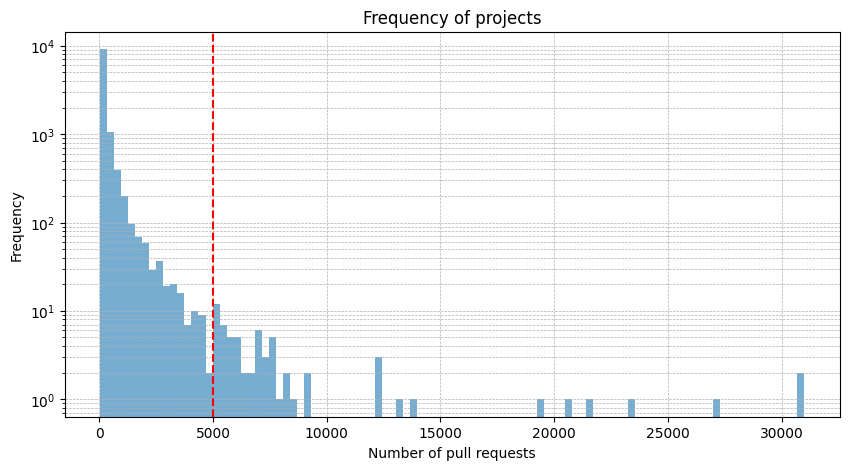

Mean number of pull requests: 298.12439893143363
Median number of pull requests: 96.0
Standard deviation of pull requests: 919.5069983233892
Maximum number of pull requests: 31007
Minimum number of pull requests: 20
Number of project with more than 5000 pull requests: 64


In [12]:
num_projects = data['project_id'].unique()
print('Number of projects: {}'.format(len(num_projects)))

projects = data['project_id'].value_counts()
project_ids = projects.index
num_pull_requests = projects.values

plt.figure(figsize=(10, 5))
plt.hist(num_pull_requests, bins=100, alpha=0.6, log=True)
plt.axvline(x=5000, color='r', linestyle='--')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Frequency of projects')
plt.xlabel('Number of pull requests')
plt.ylabel('Frequency')
plt.show()

print('Mean number of pull requests: {}'.format(np.mean(num_pull_requests)))
print('Median number of pull requests: {}'.format(np.median(num_pull_requests)))
print('Standard deviation of pull requests: {}'.format(np.std(num_pull_requests)))
print('Maximum number of pull requests: {}'.format(np.max(num_pull_requests)))  
print('Minimum number of pull requests: {}'.format(np.min(num_pull_requests)))

print('Number of project with more than 5000 pull requests: {}'.format(len(projects[num_pull_requests > 5000])))
filtered_project_ids_pr = projects[num_pull_requests > 5000].index

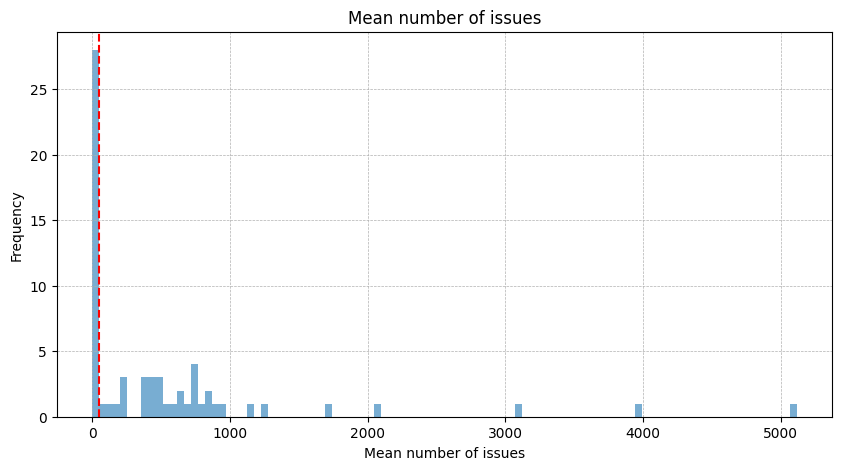

Mean number of issues: 533.6983378572712
Median number of issues: 223.95945367728729
Standard deviation of issues: 913.7737525230855
Maximum number of issues: 5114.82380743556
Minimum number of issues: 0.0
Number of project with more than 50 issues: 36


In [13]:
opened_issues = data[data['project_id'].isin(filtered_project_ids_pr)].groupby('project_id')['open_issue_num'].mean()

plt.figure(figsize=(10, 5))
plt.hist(opened_issues, bins=100, alpha=0.6)
plt.axvline(x=50, color='r', linestyle='--')
plt.xlabel('Mean number of issues')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of issues')
plt.show()

print('Mean number of issues: {}'.format(np.mean(opened_issues)))
print('Median number of issues: {}'.format(np.median(opened_issues)))
print('Standard deviation of issues: {}'.format(np.std(opened_issues)))
print('Maximum number of issues: {}'.format(np.max(opened_issues)))
print('Minimum number of issues: {}'.format(np.min(opened_issues)))

filtered_project_ids_issue = opened_issues[opened_issues > 50].index
print('Number of project with more than 50 issues: {}'.format(len(filtered_project_ids_issue)))

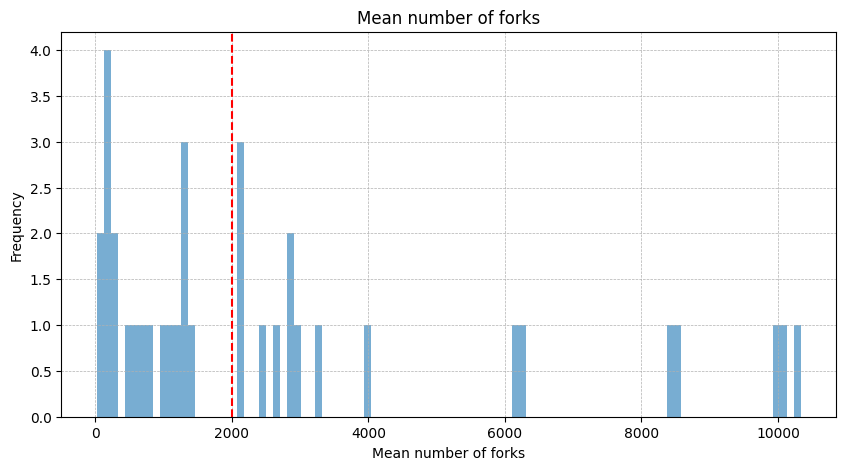

Mean number of forks: 2770.902336516114
Median number of forks: 1392.0325528649205
Standard deviation of number of forks: 3138.607774676715
Max number of forks: 10339.12191200117
Min number of forks: 17.9272476340694
Number of project with more than 2000 forks: 17


In [14]:
forks = data[data['project_id'].isin(filtered_project_ids_issue)].groupby('project_id')['fork_num'].mean()
plt.figure(figsize=(10, 5))
plt.hist(forks, bins=100, alpha=0.6)
plt.axvline(x=2000, color='r', linestyle='--')
plt.xlabel('Mean number of forks')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean number of forks')
plt.show()

print('Mean number of forks: {}'.format(forks.mean()))
print('Median number of forks: {}'.format(forks.median()))
print('Standard deviation of number of forks: {}'.format(forks.std()))
print('Max number of forks: {}'.format(forks.max()))
print('Min number of forks: {}'.format(forks.min()))

filtered_project_ids_forks = forks[forks > 2000].index
print('Number of project with more than 2000 forks: {}'.format(len(filtered_project_ids_forks)))

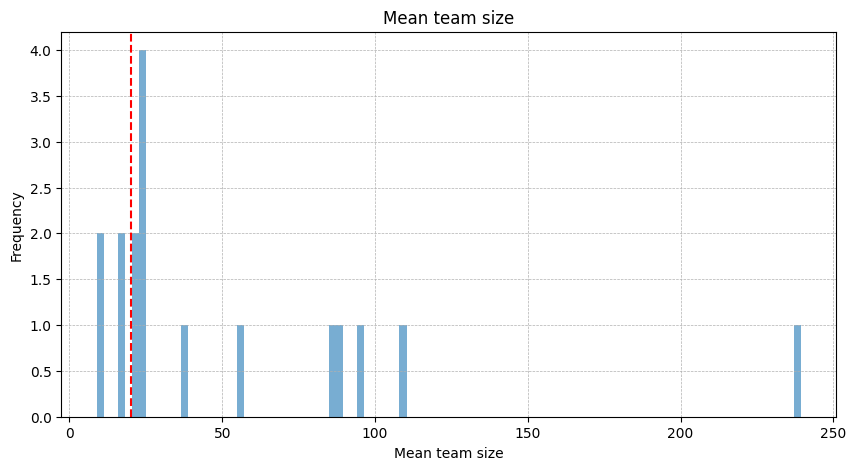

Mean team size: 53.18557840391017
Median team size: 24.21525700299157
Standard deviation: 58.21667776231618
Minimum team size: 8.850659264399722
Maximum team size: 239.44101739511768
More than 20 collaborators: 13


In [15]:

num_collaborators = data[data['project_id'].isin(filtered_project_ids_forks)].groupby('project_id')['team_size'].mean()

plt.figure(figsize=(10, 5))
plt.hist(num_collaborators, bins=100, alpha=0.6)
plt.axvline(x=20, color='r', linestyle='--')
plt.xlabel('Mean team size')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Mean team size')
plt.show()

print('Mean team size: {}'.format(num_collaborators.mean()))
print('Median team size: {}'.format(num_collaborators.median()))
print('Standard deviation: {}'.format(num_collaborators.std()))
print('Minimum team size: {}'.format(num_collaborators.min()))
print('Maximum team size: {}'.format(num_collaborators.max()))

filtered_project_ids_collab = num_collaborators[num_collaborators > 20].index
print('More than 20 collaborators: {}'.format(len(filtered_project_ids_collab)))


## Pre-processing of filtered data

In [16]:
print(data[data['project_id'].isin(filtered_project_ids_collab)]['reponame'].unique())
filtered_data = data[data['project_id'].isin(filtered_project_ids_collab)]
filtered_data

['scikit-learn' 'salt' 'metasploit-framework' 'kubernetes' 'react' 'node'
 'ansible' 'odoo' 'rails' 'matplotlib' 'ember.js' 'pandas' 'gatsby']


,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
30,31,5219,scikit-learn,scikit-learn,0,122459,NaN,3,201,504,...,1,8,199,2,60.0,0,0.000373,0,122459,0
34,35,1142,saltstack,salt,1,4534,4534.0,1,22,0,...,0,1,0,0,49.0,1,0.000622,0,4534,0
40,41,1142,saltstack,salt,1,983,983.0,1,193,0,...,0,0,0,0,3.0,0,0.000013,0,983,0
44,45,853,rapid7,metasploit-framework,1,131,131.0,1,2,0,...,0,0,0,0,159.0,0,0.000023,0,131,0
51,52,22091370,kubernetes,kubernetes,1,627,627.0,1,8,19,...,1,3,0,0,0.0,0,0.000459,0,627,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347814,3347815,48212908,pandas-dev,pandas,1,63531,63531.0,215,9804,13464,...,1,13,17,3,7.0,0,0.000274,1,10204,1
3347881,3347882,20078281,nodejs,node,1,11373,11373.0,4,16,0,...,1,9,0,0,197.0,0,0.012812,0,11373,0
3347882,3347883,853,rapid7,metasploit-framework,1,1248,1248.0,4,66,0,...,0,1,2,0,113.0,0,0.001935,0,1248,0
3347907,3347908,3905191,facebook,react,1,484,484.0,1,0,0,...,1,0,0,0,12.0,0,0.097158,0,484,0


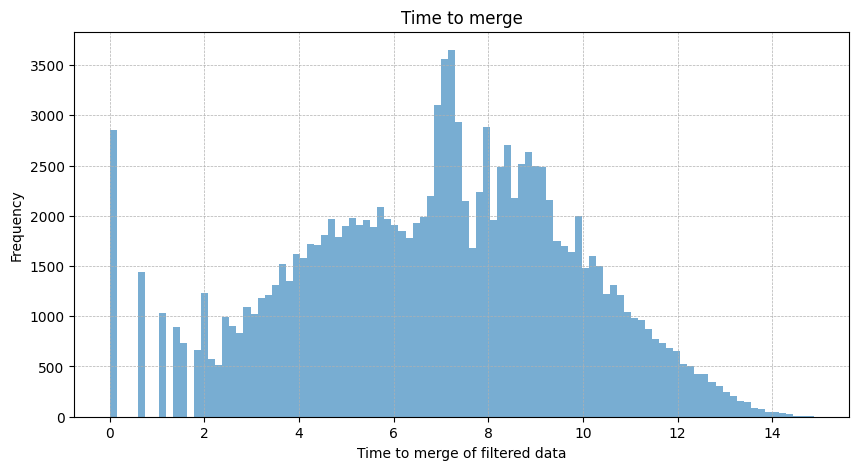

Shapiro-Wilk test for mergetime_minutes: W = 0.5751007297806933, p = 1.1400602956968472e-76
Shapiro-Wilk test for log mergetime_minutes: W = 0.9797275059260424, p = 3.8311160256280367e-26


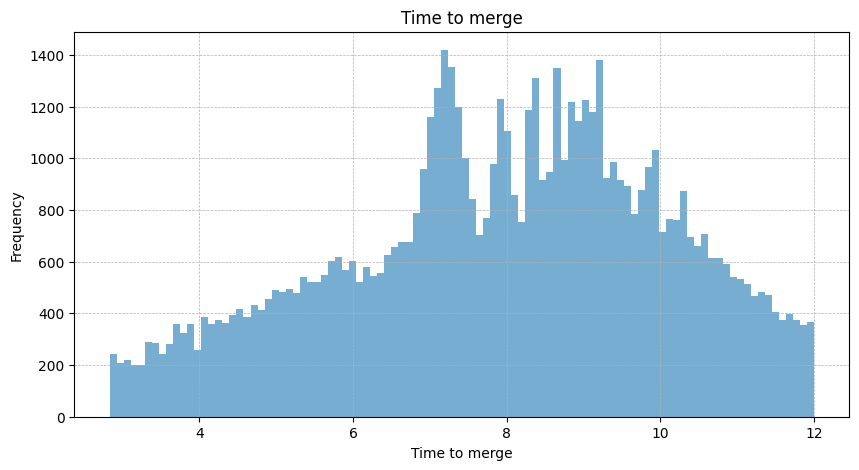

Number of pull requests before removing outliers: 186705
Number of pull requests after removing outliers: 67657


In [17]:
filtered_data = filtered_data.copy()
filtered_data.loc[:, 'log_mergetime_minutes'] = np.log(filtered_data['mergetime_minutes'] + 1)
filtered_data.loc[:, 'log_lifetime_minutes'] = np.log(filtered_data['lifetime_minutes'] + 1)

# merged data
plt.figure(figsize=(10, 5))
plt.hist(filtered_data['log_mergetime_minutes'], bins=100, alpha=0.6)
plt.xlabel('Time to merge of filtered data')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Time to merge')
plt.show()

Q1 = filtered_data['log_mergetime_minutes'].quantile(0.25)
Q3 = filtered_data['log_mergetime_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

merged_data = filtered_data[(filtered_data['log_mergetime_minutes'] >= lower_bound) & (filtered_data['log_mergetime_minutes'] <= upper_bound)]
merged_data = merged_data[merged_data['mergetime_minutes'] > 15]
merged_data = merged_data[merged_data['files_changed'] > 0]
merged_data = merged_data[merged_data['src_churn'] > 0]
merged_data = merged_data[merged_data['log_mergetime_minutes'] <= 12]
merged_data = merged_data[merged_data['first_response_time'] >= 0]

sample = merged_data['mergetime_minutes'].sample(n=5000, random_state=1)
stat, p = shapiro(sample)
print('Shapiro-Wilk test for mergetime_minutes: W = {}, p = {}'.format(stat, p))
sample = merged_data['log_mergetime_minutes'].sample(n=5000, random_state=1)
stat, p = shapiro(sample)
print('Shapiro-Wilk test for log mergetime_minutes: W = {}, p = {}'.format(stat, p))

plt.figure(figsize=(10, 5))
plt.hist(merged_data['log_mergetime_minutes'], bins=100, alpha=0.6)
plt.xlabel('Time to merge')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Time to merge')
plt.show()

print('Number of pull requests before removing outliers: {}'.format(len(filtered_data)))
print('Number of pull requests after removing outliers: {}'.format(len(merged_data)))

In [18]:
merged_data.to_csv('./data/merged_data.csv', index=False)